## 1. Import Library

In [1]:
# Standard libraries
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras

# Add src to path
sys.path.append('..')

# Local modules
from src.data_generator import SystemLogGenerator
from src.preprocessing import LogPreprocessor, FeatureExtractor
from src.tokenizer import LogTokenizer
from src.model import create_model, get_callbacks

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

2026-01-04 13:56:29.274273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2
Keras version: 3.13.0
NumPy version: 1.26.4
Pandas version: 2.3.3


In [3]:
# Set random seed untuk reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 2. Generate Data Sintetis

In [4]:
# Konfigurasi generator
NUM_LOGS = 10000
ANOMALY_RATIO = 0.15  # 15% anomali

# Generate data
generator = SystemLogGenerator(seed=SEED, anomaly_ratio=ANOMALY_RATIO)
df = generator.generate_logs(NUM_LOGS)

print(f"\nDataset shape: {df.shape}")
print(f"\nKolom: {df.columns.tolist()}")

Generating 8500 normal logs...


100%|█████████████████████████████████████████████████████████| 8500/8500 [00:00<00:00, 31416.32it/s]


Generating 1500 anomaly logs...


100%|█████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 28933.55it/s]


Dataset shape: (10000, 4)

Kolom: ['timestamp', 'log_message', 'label', 'anomaly_type']


In [5]:
# Tampilkan sample data
print("Sample Data:")
df.head(10)

Sample Data:


,timestamp,log_message,label,anomaly_type
0,2026-01-03 13:57:05,systemd[1]: Started nginx.service,0,normal
1,2026-01-03 13:57:12,[INFO] User postgres logged in successfully,0,normal
2,2026-01-03 13:57:19,Connection received: host=192.168.167.71 user=...,0,normal
3,2026-01-03 13:57:23,su: FAILED SU (to root) mysql on pts/0,1,privilege_escalation
4,2026-01-03 13:57:35,[INFO] Cache hit for key: cache_key_286,0,normal
5,2026-01-03 13:57:37,session closed for user admin,0,normal
6,2026-01-03 13:58:10,[INFO] Cache hit for key: cache_key_728,0,normal
7,2026-01-03 13:58:12,192.168.166.57 - - [04/Jan/2026:01:26:21 +0700...,0,normal
8,2026-01-03 13:58:21,[INFO] Application started successfully,0,normal
9,2026-01-03 13:58:36,MySQL server started with process id 14659,0,normal


## 3. Eksplorasi Data (EDA)

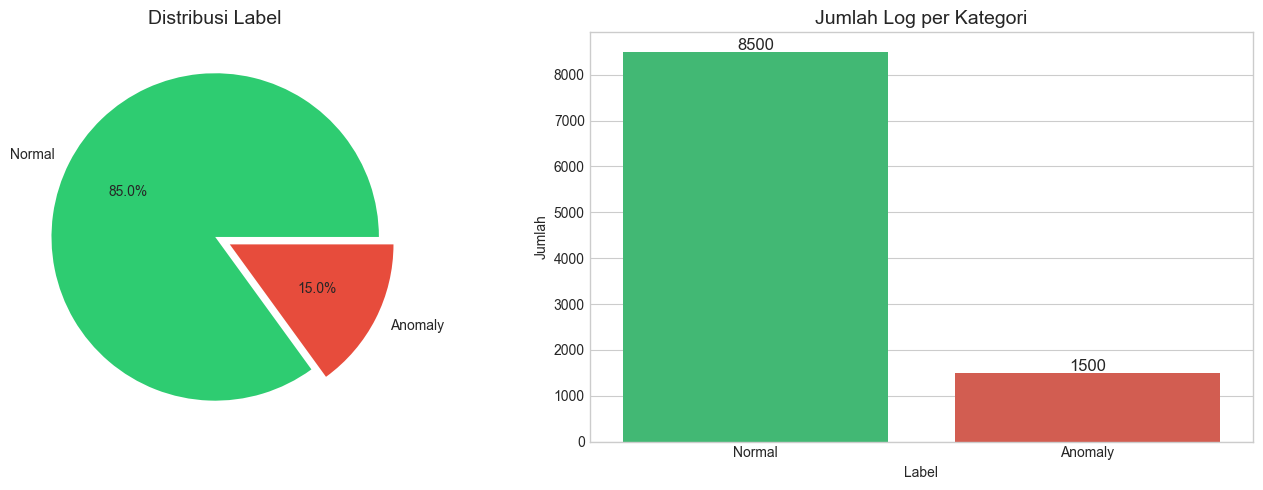


Normal logs: 8500 (85.0%)
Anomaly logs: 1500 (15.0%)


In [6]:
# Distribusi label
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
label_counts = df['label'].value_counts()
labels = ['Normal', 'Anomaly']
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(label_counts, labels=labels, autopct='%1.1f%%', colors=colors, explode=(0, 0.1))
axes[0].set_title('Distribusi Label', fontsize=14)

# Bar chart
sns.countplot(data=df, x='label', ax=axes[1], palette=colors)
axes[1].set_xticklabels(['Normal', 'Anomaly'])
axes[1].set_title('Jumlah Log per Kategori', fontsize=14)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Jumlah')

# Add count labels
for i, v in enumerate(label_counts):
    axes[1].text(i, v + 50, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nNormal logs: {label_counts[0]} ({label_counts[0]/len(df)*100:.1f}%)")
print(f"Anomaly logs: {label_counts[1]} ({label_counts[1]/len(df)*100:.1f}%)")

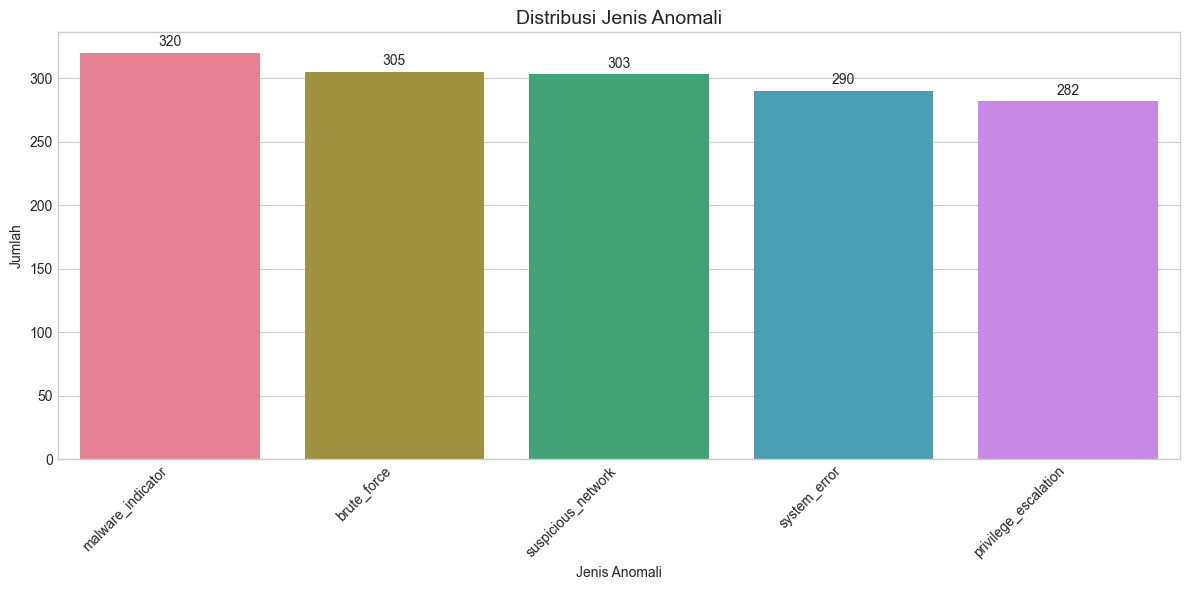

In [7]:
# Distribusi jenis anomali
anomaly_df = df[df['label'] == 1]

plt.figure(figsize=(12, 6))
anomaly_dist = anomaly_df['anomaly_type'].value_counts()
colors = sns.color_palette('husl', len(anomaly_dist))

ax = sns.barplot(x=anomaly_dist.index, y=anomaly_dist.values, palette=colors)
plt.title('Distribusi Jenis Anomali', fontsize=14)
plt.xlabel('Jenis Anomali')
plt.ylabel('Jumlah')
plt.xticks(rotation=45, ha='right')

# Add count labels
for i, v in enumerate(anomaly_dist.values):
    ax.text(i, v + 5, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

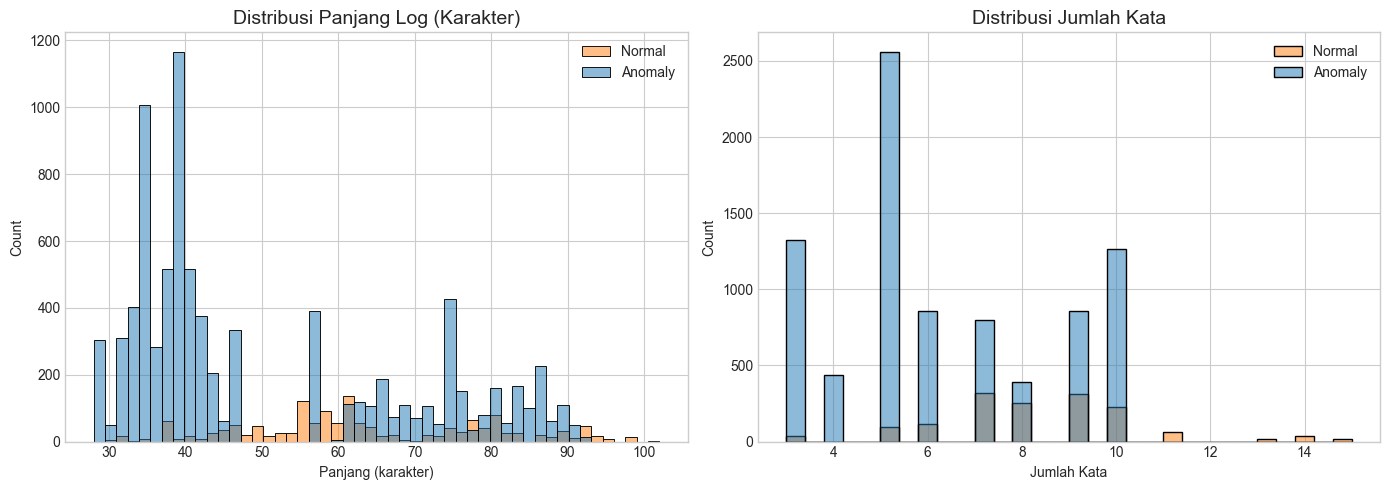


Statistik Panjang Log:
      log_length                                                       \
           count       mean        std   min   25%   50%   75%    max   
label                                                                   
0         8500.0  49.901176  18.522381  28.0  36.0  40.0  66.0   92.0   
1         1500.0  63.826667  15.932541  30.0  54.0  61.0  78.0  102.0   

      word_count                                                
           count      mean       std  min  25%  50%  75%   max  
label                                                           
0         8500.0  6.210824  2.331312  3.0  5.0  5.0  8.0  10.0  
1         1500.0  8.230000  2.131383  3.0  7.0  8.0  9.0  15.0  


In [8]:
# Analisis panjang log
df['log_length'] = df['log_message'].str.len()
df['word_count'] = df['log_message'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Log length distribution
sns.histplot(data=df, x='log_length', hue='label', bins=50, ax=axes[0])
axes[0].set_title('Distribusi Panjang Log (Karakter)', fontsize=14)
axes[0].set_xlabel('Panjang (karakter)')
axes[0].legend(['Normal', 'Anomaly'])

# Word count distribution
sns.histplot(data=df, x='word_count', hue='label', bins=30, ax=axes[1])
axes[1].set_title('Distribusi Jumlah Kata', fontsize=14)
axes[1].set_xlabel('Jumlah Kata')
axes[1].legend(['Normal', 'Anomaly'])

plt.tight_layout()
plt.show()

print("\nStatistik Panjang Log:")
print(df.groupby('label')[['log_length', 'word_count']].describe())

In [9]:
# Contoh log normal vs anomali
print("=" * 60)
print("CONTOH LOG NORMAL:")
print("=" * 60)
for log in df[df['label'] == 0]['log_message'].sample(5).values:
    print(f"  • {log}")

print("\n" + "=" * 60)
print("CONTOH LOG ANOMALI:")
print("=" * 60)
for _, row in df[df['label'] == 1].sample(5).iterrows():
    print(f"  [{row['anomaly_type']}]")
    print(f"  • {row['log_message']}")
    print()

CONTOH LOG NORMAL:
  • [INFO] Application started successfully
  • Received disconnect from 192.168.79.103 port 15750:11: disconnected by user
  • MySQL server started with process id 2578
  • PostgreSQL database system is ready to accept connections
  • session opened for user admin by (uid=0)

CONTOH LOG ANOMALI:
  [privilege_escalation]
  • mysql: user NOT in sudoers; TTY=pts/0; PWD=/home/mysql; USER=root; COMMAND=/bin/bash

  [malware_indicator]
  • ALERT: Reverse shell connection attempt to 192.42.188.208:2917

  [malware_indicator]
  • WARNING: Cryptominer activity detected on process 64014

  [brute_force]
  • Failed password for admin from 45.33.207.191 port 17757 ssh2

  [system_error]
  • kernel: [667.206791] I/O error, dev docker0, sector 5847236



## 4. Preprocessing & Tokenization

In [10]:
# Preprocessing
preprocessor = LogPreprocessor(
    lowercase=True,
    remove_special_chars=True,
    remove_numbers=False
)

# Apply preprocessing
df['processed_log'] = df['log_message'].apply(preprocessor.clean_text)

print("Contoh hasil preprocessing:")
for i in range(3):
    print(f"\nOriginal: {df['log_message'].iloc[i][:80]}...")
    print(f"Processed: {df['processed_log'].iloc[i][:80]}...")

Contoh hasil preprocessing:

Original: systemd[1]: Started nginx.service...
Processed: systemd<PID> started nginx service...

Original: [INFO] User postgres logged in successfully...
Processed: info user postgres logged in successfully...

Original: Connection received: host=192.168.167.71 user=guest database=analytics...
Processed: connection received host <IP> user guest database analytics...


In [11]:
# Tokenization
MAX_WORDS = 10000
MAX_LENGTH = 50

tokenizer = LogTokenizer(max_words=MAX_WORDS, max_length=MAX_LENGTH)
X = tokenizer.fit_transform(df['processed_log'].tolist())
y = df['label'].values

print(f"Vocabulary size: {tokenizer.get_vocabulary_size()}")
print(f"Sequence shape: {X.shape}")
print(f"\nContoh sequence: {X[0][:20]}...")

Vocabulary size: 3863
Sequence shape: (10000, 50)

Contoh sequence: [13 12 16 43 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]...


In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=SEED, stratify=y_train
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 6800 samples
Validation set: 1200 samples
Test set: 2000 samples


## 5. Build Model

In [13]:
# Konfigurasi model
EMBEDDING_DIM = 128
LSTM_UNITS = [64, 32]
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001

vocab_size = tokenizer.get_vocabulary_size()

# Build model LSTM
model = create_model(
    model_type='lstm',
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_LENGTH,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE
)

model.build()
model.compile(learning_rate=LEARNING_RATE)
model.summary()

Model: "LSTM_AnomalyDetector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 128)        │       494,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 556,833 (2.12 MB)

 Trainable params: 556,833 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Visualisasi arsitektur model
tf.keras.utils.plot_model(
    model.model,
    show_shapes=True,
    show_layer_names=True,
    dpi=100
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 6. Training Model

In [15]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 30

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Training
print("Starting training...")
history = model.model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Starting training...
Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8726 - loss: 1.0685 - val_accuracy: 0.9817 - val_loss: 0.2092 - learning_rate: 0.0010
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.9715 - loss: 0.2067 - val_accuracy: 0.9817 - val_loss: 0.1355 - learning_rate: 0.0010
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.9787 - loss: 0.1464 - val_accuracy: 0.9817 - val_loss: 0.1123 - learning_rate: 0.0010
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9703 - loss: 0.1657 - val_accuracy: 0.9817 - val_loss: 0.1348 - learning_rate: 0.0010
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.9676 - loss: 0.1636 - val_accuracy: 0.8958 - val_loss: 0.2744 - learning_rate: 0.0010
Epoch 6/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8839 - loss: 0.2780
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - a

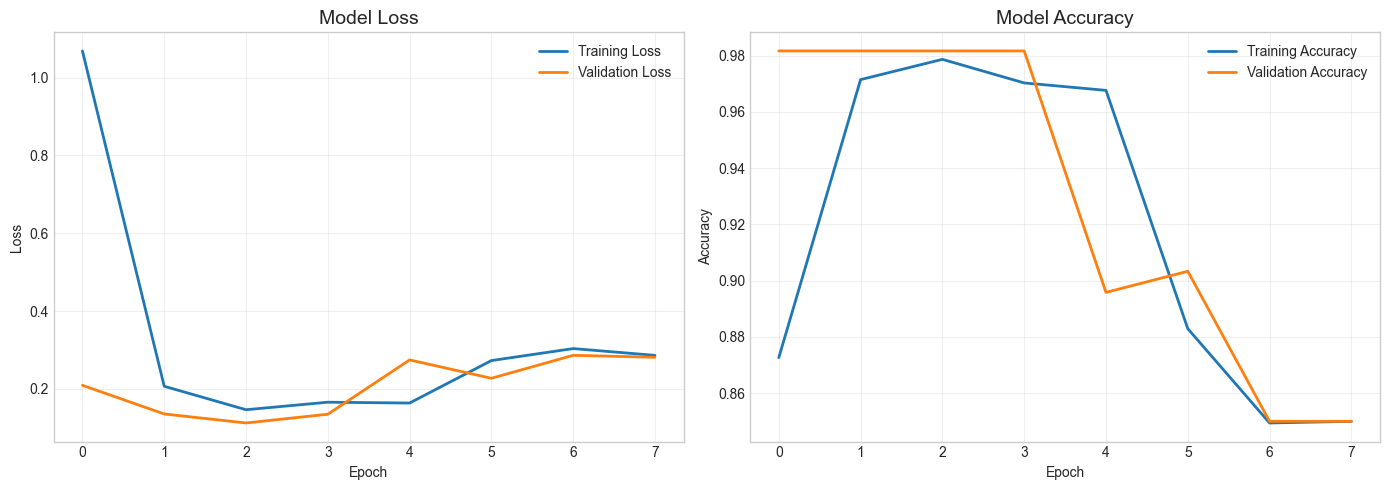


Best Validation Accuracy: 0.9817
Best Validation Loss: 0.1123


In [16]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")

## 7. Evaluasi Model

In [17]:
# Prediksi pada test set
y_pred_proba = model.model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      1700
     Anomaly       1.00      0.88      0.93       300

    accuracy                           0.98      2000
   macro avg       0.99      0.94      0.96      2000
weighted avg       0.98      0.98      0.98      2000



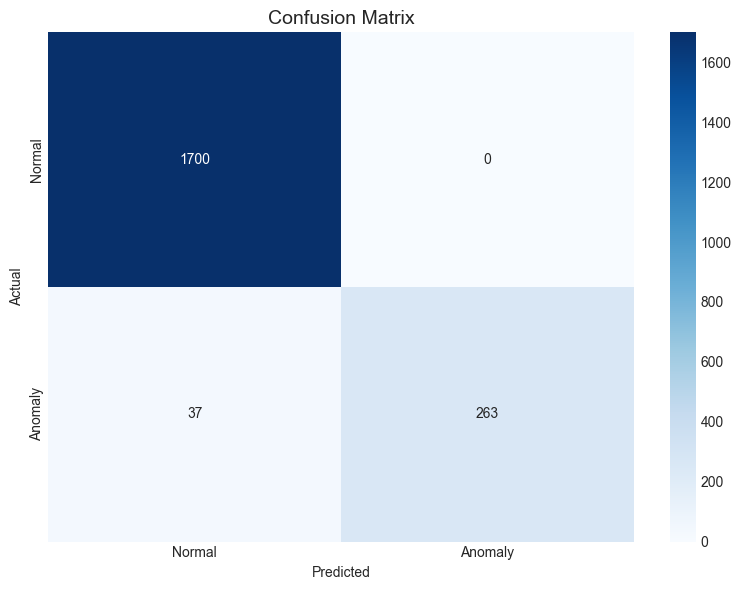


True Negatives (Normal → Normal): 1700
False Positives (Normal → Anomaly): 0
False Negatives (Anomaly → Normal): 37
True Positives (Anomaly → Anomaly): 263


In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Normal', 'Anomaly'],
    yticklabels=['Normal', 'Anomaly']
)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Normal → Normal): {tn}")
print(f"False Positives (Normal → Anomaly): {fp}")
print(f"False Negatives (Anomaly → Normal): {fn}")
print(f"True Positives (Anomaly → Anomaly): {tp}")

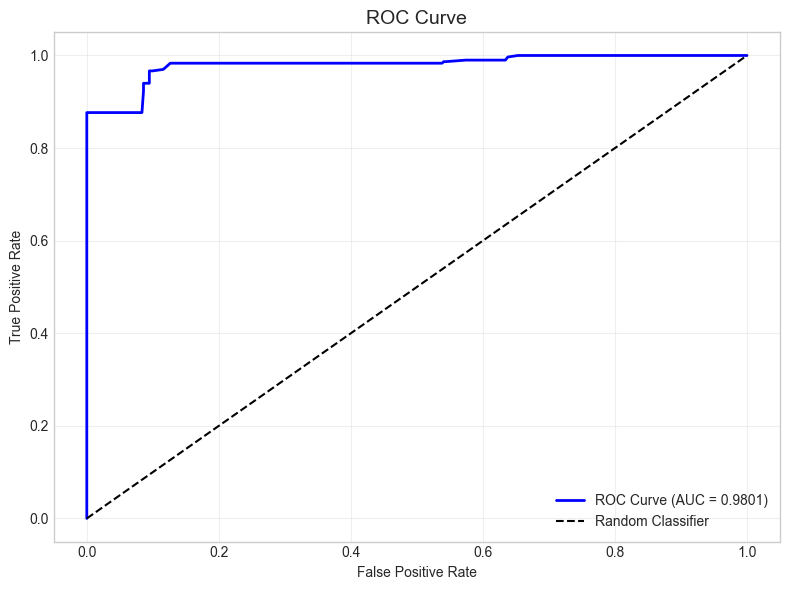

ROC-AUC Score: 0.9801


In [19]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

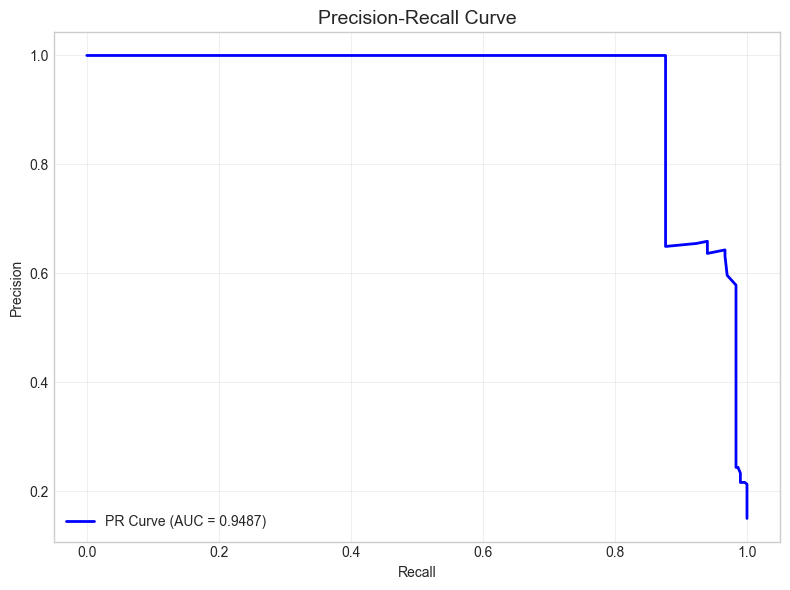

PR-AUC Score: 0.9487


In [20]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, 'b-', linewidth=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PR-AUC Score: {pr_auc:.4f}")

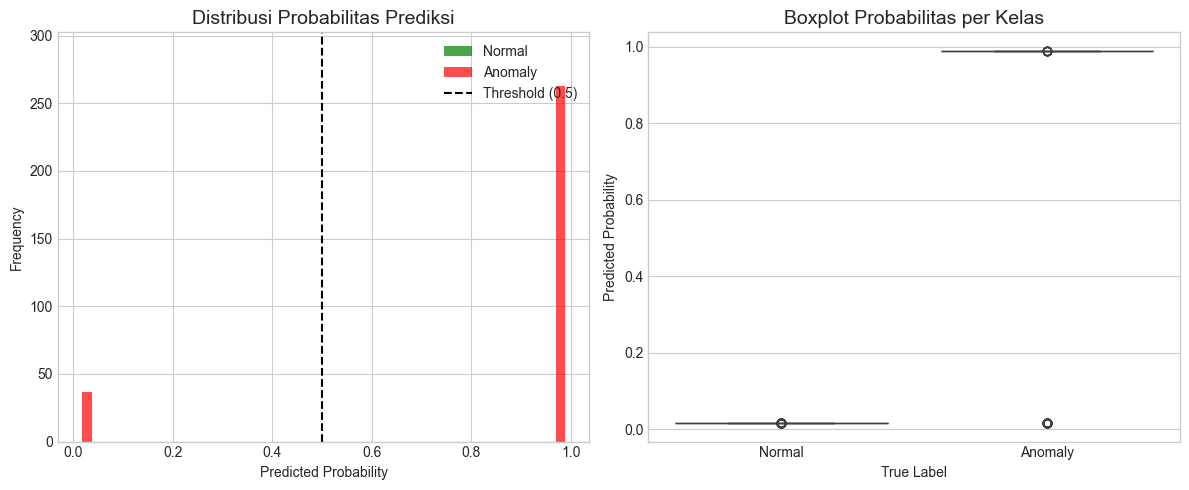

In [21]:
# Distribusi probabilitas prediksi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='Normal', color='green')
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='Anomaly', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribusi Probabilitas Prediksi', fontsize=14)
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(x=y_test, y=y_pred_proba.flatten())
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.xlabel('True Label')
plt.ylabel('Predicted Probability')
plt.title('Boxplot Probabilitas per Kelas', fontsize=14)

plt.tight_layout()
plt.show()

## 8. Prediksi & Analisis

In [22]:
# Fungsi untuk prediksi log baru
def predict_logs(logs, preprocessor, tokenizer, model, threshold=0.5):
    """
    Prediksi anomali pada log baru.
    """
    # Preprocessing
    processed = [preprocessor.clean_text(log) for log in logs]
    
    # Tokenization
    sequences = tokenizer.transform(processed)
    
    # Prediksi
    probabilities = model.model.predict(sequences, verbose=0)
    predictions = (probabilities > threshold).astype(int).flatten()
    
    # Hasil
    results = []
    for i, (log, prob, pred) in enumerate(zip(logs, probabilities.flatten(), predictions)):
        results.append({
            'log': log,
            'probability': prob,
            'prediction': 'ANOMALY' if pred == 1 else 'NORMAL'
        })
    
    return results

In [23]:
# Test dengan log baru
test_logs = [
    "Accepted password for user from 192.168.1.50 port 22 ssh2",
    "systemd[1]: Started nginx.service",
    "Connection received: host=192.168.1.100 user=admin database=production",
    "Failed password for invalid user admin from 185.220.101.1 port 22 ssh2",
    "Failed password for invalid user root from 185.220.101.1 port 22 ssh2",
    "Failed password for invalid user test from 185.220.101.1 port 22 ssh2",
    "kernel: Out of memory: Kill process 12345 (java) score 950",
    "ALERT: Suspicious process detected: cryptominer (PID: 99999)",
    "admin: user NOT in sudoers; TTY=pts/0; PWD=/home/admin; USER=root; COMMAND=/bin/bash",
    "[INFO] Application started successfully",
]

results = predict_logs(test_logs, preprocessor, tokenizer, model)

print("=" * 80)
print("HASIL PREDIKSI")
print("=" * 80)

for i, result in enumerate(results, 1):
    icon = "🔴" if result['prediction'] == 'ANOMALY' else "🟢"
    print(f"\n{i}. {icon} [{result['prediction']}] (Prob: {result['probability']:.4f})")
    print(f"   {result['log']}")

HASIL PREDIKSI

1. 🟢 [NORMAL] (Prob: 0.0170)
   Accepted password for user from 192.168.1.50 port 22 ssh2

2. 🟢 [NORMAL] (Prob: 0.0170)
   systemd[1]: Started nginx.service

3. 🟢 [NORMAL] (Prob: 0.0170)
   Connection received: host=192.168.1.100 user=admin database=production

4. 🔴 [ANOMALY] (Prob: 0.9886)
   Failed password for invalid user admin from 185.220.101.1 port 22 ssh2

5. 🔴 [ANOMALY] (Prob: 0.9886)
   Failed password for invalid user root from 185.220.101.1 port 22 ssh2

6. 🔴 [ANOMALY] (Prob: 0.9886)
   Failed password for invalid user test from 185.220.101.1 port 22 ssh2

7. 🔴 [ANOMALY] (Prob: 0.9886)
   kernel: Out of memory: Kill process 12345 (java) score 950

8. 🔴 [ANOMALY] (Prob: 0.9886)
   ALERT: Suspicious process detected: cryptominer (PID: 99999)

9. 🔴 [ANOMALY] (Prob: 0.9886)
   admin: user NOT in sudoers; TTY=pts/0; PWD=/home/admin; USER=root; COMMAND=/bin/bash

10. 🟢 [NORMAL] (Prob: 0.0170)
   [INFO] Application started successfully


In [24]:
# Analisis kesalahan prediksi
errors_idx = np.where(y_test != y_pred)[0]

print(f"Total kesalahan prediksi: {len(errors_idx)} ({len(errors_idx)/len(y_test)*100:.2f}%)")

# False Positives (Normal yang diprediksi Anomaly)
fp_idx = errors_idx[y_test[errors_idx] == 0]
print(f"\nFalse Positives: {len(fp_idx)}")

# False Negatives (Anomaly yang diprediksi Normal)
fn_idx = errors_idx[y_test[errors_idx] == 1]
print(f"False Negatives: {len(fn_idx)}")

Total kesalahan prediksi: 37 (1.85%)

False Positives: 0
False Negatives: 37


In [25]:
# Contoh False Negatives (yang paling berbahaya)
print("\n" + "=" * 80)
print("CONTOH FALSE NEGATIVES (Anomali yang terlewat)")
print("=" * 80)

if len(fn_idx) > 0:
    df_test = df.iloc[X_test.shape[0]:].reset_index(drop=True)
    for idx in fn_idx[:5]:
        print(f"\nProbability: {y_pred_proba[idx][0]:.4f}")
        print(f"Log: {df['log_message'].iloc[idx][:100]}...")
else:
    print("Tidak ada False Negatives!")


CONTOH FALSE NEGATIVES (Anomali yang terlewat)

Probability: 0.0170
Log: ALERT: Reverse shell connection attempt to 185.220.99.134:36532...

Probability: 0.0170
Log: Accepted password for www-data from 192.168.194.40 port 31085 ssh2...

Probability: 0.0170
Log: Connection received: host=192.168.106.91 user=www-data database=staging...

Probability: 0.0170
Log: [INFO] Cache hit for key: cache_key_487...

Probability: 0.0170
Log: 192.42.117.72 - - [04/Jan/2026:08:09:45 +0700] "POST /login HTTP/1.1" 401 8748...


## 9. Simpan Model

In [26]:
# Simpan model
import os

save_dir = '../models/saved_models'
os.makedirs(save_dir, exist_ok=True)

# Simpan model
model_path = os.path.join(save_dir, 'lstm_anomaly_detector.keras')
model.model.save(model_path)
print(f"Model saved to: {model_path}")

# Simpan tokenizer
tokenizer_path = os.path.join(save_dir, 'tokenizer')
tokenizer.save(tokenizer_path)
print(f"Tokenizer saved to: {tokenizer_path}")

Model saved to: ../models/saved_models/lstm_anomaly_detector.keras
Tokenizer saved to ../models/saved_models/tokenizer
Tokenizer saved to: ../models/saved_models/tokenizer


## 10. Ringkasan

In [27]:
# Ringkasan hasil
accuracy = (y_pred == y_test).mean()
precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision_val * recall_val / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0

print("\n" + "=" * 60)
print("📊 RINGKASAN HASIL EKSPERIMEN")
print("=" * 60)

print(f"\n📁 Dataset:")
print(f"   • Total samples: {len(df)}")
print(f"   • Normal: {len(df[df['label']==0])} ({len(df[df['label']==0])/len(df)*100:.1f}%)")
print(f"   • Anomaly: {len(df[df['label']==1])} ({len(df[df['label']==1])/len(df)*100:.1f}%)")

print(f"\n🧠 Model: LSTM")
print(f"   • Embedding dim: {EMBEDDING_DIM}")
print(f"   • LSTM units: {LSTM_UNITS}")
print(f"   • Dropout: {DROPOUT_RATE}")

print(f"\n📈 Metrik Evaluasi:")
print(f"   • Accuracy:  {accuracy:.4f}")
print(f"   • Precision: {precision_val:.4f}")
print(f"   • Recall:    {recall_val:.4f}")
print(f"   • F1-Score:  {f1:.4f}")
print(f"   • ROC-AUC:   {roc_auc:.4f}")
print(f"   • PR-AUC:    {pr_auc:.4f}")

print("\n" + "=" * 60)
print("✅ Eksperimen selesai!")
print("=" * 60)


📊 RINGKASAN HASIL EKSPERIMEN

📁 Dataset:
   • Total samples: 10000
   • Normal: 8500 (85.0%)
   • Anomaly: 1500 (15.0%)

🧠 Model: LSTM
   • Embedding dim: 128
   • LSTM units: [64, 32]
   • Dropout: 0.3

📈 Metrik Evaluasi:
   • Accuracy:  0.9815
   • Precision: 1.0000
   • Recall:    0.8767
   • F1-Score:  0.9343
   • ROC-AUC:   0.9801
   • PR-AUC:    0.9487

✅ Eksperimen selesai!
